In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import matplotlib.colors as mcolors
import cartopy.feature
import numpy as np
import pandas as pd
import scipy
import datetime
import cartopy
from metpy.units import units
import cartopy.crs as ccrs
import pickle
import os
import glob
import subprocess
import dask
from joblib import Parallel, delayed
from geopy.distance import distance 
import cmocean as cmo
import cmcrameri.cm as cmc
from matplotlib.colors import TwoSlopeNorm

from scipy.stats import linregress

import concurrent.futures

### Load MOAAP functions
import sys
sys.path.append('/work/aa0049/a271122/MOAAP/MOAAP/')
from src.utils import *
from src.Corrections import * 
from src.Enumerations import Month, Season, Experiments, Domains
from src.xarray_util import create_obj_from_dict,  ObjectContainer,  load_tracking_objects
from src.plot_funcs import plot_contourf_rotated_grid #, plot_unstructured_rotated_grid

from src.GridPoints import Domain


/work/aa0049/a271122/MOAAP/MOAAP/src/xarray_util.py:28: AccessorRegistrationWarning: registration of accessor <class 'src.xarray_util.Accessor'> under name 'get' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class Accessor:


In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
plt.rcParams.update({
    'axes.titlesize': 13,        # Title size
    'axes.labelsize': 12,         # Axis label size
    'lines.linewidth': 2,         # Line width
    'lines.markersize': 7,       # Marker size for lines
    'xtick.labelsize': 14,        # X-tick label size
    'ytick.labelsize': 14         # Y-tick label size
})

In [4]:
ds=xr.open_dataset('/work/aa0049/a271041/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2/post/yearly/T_2M/T_2M_2020010100-2020123123.ncz')

# extract the rotated coordinate system
crs_rot = ccrs.RotatedPole(pole_longitude=ds.rotated_pole.attrs['grid_north_pole_longitude'],\
                           pole_latitude=ds.rotated_pole.attrs['grid_north_pole_latitude'])

In [5]:
from enum import Enum

class Domains(Enum):
    # JLa custom domains
    NORTH_ATLANTIC_JLa = Domain(north=80, south=67, east=60, west=-30)
    BEAUFORT_SIBERIAN_JLa = Domain(north=80, south=70, east=-120, west=120)
    CENTRAL_ARCTIC_JLa = Domain(north=90, south=80, east=180, west=-180)

gridspacing=0.75
lat=np.arange(-90, 90+gridspacing,gridspacing)
lon=np.arange(-180, 180+gridspacing,gridspacing)
ds_dummy = xr.Dataset({"dummy": (("lat", "lon"), np.ones([len(lat), len(lon)]))},coords={"lon": lon,"lat": lat})


dd=ds_dummy.copy()
mask_domain_CentralArctic=dd.dummy.where(dd.lat>80).notnull()
mask_domain_NorthAtlantic=dd.dummy.where((dd.lat<=80) & (dd.lat>67) & (dd.lon>-30) & (dd.lon<60)).notnull()
mask_domain_BeaufortSiberianSea1=dd.dummy.where((dd.lat<=80) & (dd.lat>70) & (dd.lon>120)).notnull()
mask_domain_BeaufortSiberianSea2=dd.dummy.where((dd.lat<=80) & (dd.lat>70) & (dd.lon<-120)).notnull()

mask_domain_BeaufortSiberianSea = mask_domain_BeaufortSiberianSea1 | mask_domain_BeaufortSiberianSea2

mask_domains = {
    "CentralArctic": {"mask": mask_domain_CentralArctic, "color": 'darkred',"north":90,"south":80,"east":180,"west":-180},
    "NorthAtlantic": {"mask": mask_domain_NorthAtlantic, "color": 'darkblue',"north":80,"south":67,"east":60,"west":-30},
    "BeaufortSiberianSea": {"mask": mask_domain_BeaufortSiberianSea, "color": "gold","north":80,"south":70,"east":120,"west":-120},
}
domains = ["NorthAtlantic","CentralArctic","BeaufortSiberianSea"]

In [6]:
ICON_NorESM_path_his = '/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/NorESM2-MM/historical/r1i1p1f1/ICON-CLM-202401-1-1/v1-r1/'

In [7]:
ICON_NorESM_path_ssp = '/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/NorESM2-MM/ssp370/r1i1p1f1/ICON-CLM-202401-1-1/v1-r1/'

In [8]:
ICON_CNRM_path_his = '/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/CNRM-ESM2-1/historical/r1i1p1f2/ICON-CLM-2-6-6-1-1/v1-r1/'

In [9]:
ICON_CNRM_path_ssp = '/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/CNRM-ESM2-1/ssp370/r1i1p1f2/ICON-CLM-2-6-6-1-1/v1-r1/'

### SIC

In [10]:
ds_land = xr.open_dataset('/work/aa0049/a271109/spice-v2.2/chain/work/polarres_wp3_cmip_CNRM_ssp370/post/yearly/FR_LAND/FR_LAND.ncz')
ds_lake = xr.open_dataset('/work/aa0049/a271109/spice-v2.2/chain/work/polarres_wp3_cmip_CNRM_ssp370/post/yearly/FR_LAKE/FR_LAKE.ncz')

#NorESM SIC
ds_ice_ssp = xr.open_mfdataset('/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/NorESM2-MM/ssp370/r1i1p1f1/ICON-CLM-202401-1-1/v1-r1/mon/siconca/v20250601/siconca_ARC-12_NorESM2-MM_ssp370_r1i1p1f1_CLMcom-AWI_ICON-CLM-202401-1-1_v1-r1_mon_*.nc',decode_times=False,chunks = {'time':10})
# Replace this if time is a coordinate
months_since_1950 = ds_ice_ssp['time'].values
ds_ice_ssp['time'] = pd.date_range(start='2015-01-01', periods=len(months_since_1950), freq='MS')
ds_ice_ssp =ds_ice_ssp.sel(time=slice("2070-01-01","2099-12-31"))
siconc_mean_ssp= ds_ice_ssp.siconca.sel(time=ds_ice_ssp.siconca.time.dt.month.isin([12, 1, 2])).mean(dim='time') #Winter sea ice
NorESM_sic_ssp = siconc_mean_ssp.where(((ds_land.FR_LAND+ds_lake.FR_LAKE)<0.5))


#NorESM_sic_his = 


#CNRM SIC
ds_ice = xr.open_mfdataset('/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/CNRM-ESM2-1/ssp370/r1i1p1f2/ICON-CLM-2-6-6-1-1/v1-r1/mon/siconca/v20250601/siconca_*.nc',chunks = {'time':10})
ds_ice = ds_ice.sel(time=slice("2070-01-15", "2099-12-16"))
siconc_mean = ds_ice.siconca.sel(time=ds_ice.siconca.time.dt.month.isin([12, 1, 2])).mean(dim='time') #Winter sea ice

CNRM_sic_ssp = siconc_mean.where(((ds_land.FR_LAND+ds_lake.FR_LAKE)<0.5))


#CNRM_sic_his = 

In [49]:

ds_ice_his 

<xarray.Dataset>
Dimensions:       (time: 360, bnds: 2, rlat: 582, rlon: 577)
Coordinates:
  * time          (time) float64 1.28e+04 1.283e+04 ... 2.37e+04 2.373e+04
    lon           (rlat, rlon) float32 dask.array<chunksize=(582, 577), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(582, 577), meta=np.ndarray>
  * rlon          (rlon) float32 -29.9 -29.8 -29.7 -29.6 ... 27.4 27.5 27.6 27.7
  * rlat          (rlat) float32 -24.2 -24.1 -24.0 -23.9 ... 33.6 33.7 33.8 33.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    siconca       (time, rlat, rlon) float32 dask.array<chunksize=(10, 582, 577), meta=np.ndarray>
Attributes: (12/34)
    CDI:                     Climate Data Interface version 2.2.4 (https://mp...
    Conventions:             CF-1.11
    source:                  ICON model in Climate Limited-area Mode (ICON-CL...
    institution:             Climate Limited-area Modelling Community (CLMcom...
    conventionsURL:          http://www.cfconventions.org
    title:                   AWI-ICON-2024-01 model output prepared for Polar...
    ...                      ...
    license:                 https://cordex.org/data-access/cordex-cmip6-data...
    references:              https://www.icon-model.org/publications/referenc...
    variable_id:             siconca
    product:                 model-output
    config_icon-clm:         CORDEX-CMIP6_CMIP6_DD_ARC-12_CLMcom-AWI_NorESM2-...
    CDO:                     Climate Data Operators version 2.2.2 (https://mp...

In [59]:
ds_ice_his = xr.open_mfdataset('/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/NorESM2-MM/historical/r1i1p1f1/ICON-CLM-202401-1-1/v1-r1/mon/siconca/v20250601/siconca_ARC-12_NorESM2-MM_historical_r1i1p1f1_CLMcom-AWI_ICON-CLM-202401-1-1_v1-r1_mon_*.nc',decode_times=False,chunks = {'time':10})
# Replace this if time is a coordinate
months_since_1950 = ds_ice_his['time'].values
ds_ice_his['time'] = pd.date_range(start='1985-01-01', periods=len(months_since_1950), freq='MS')
siconc_mean_his= ds_ice_his.siconca.sel(time=ds_ice_his.siconca.time.dt.month.isin([12, 1, 2])).mean(dim='time') #Winter sea ice
NorESM_sic_his = siconc_mean_his.where(((ds_land.FR_LAND+ds_lake.FR_LAKE)<0.5))



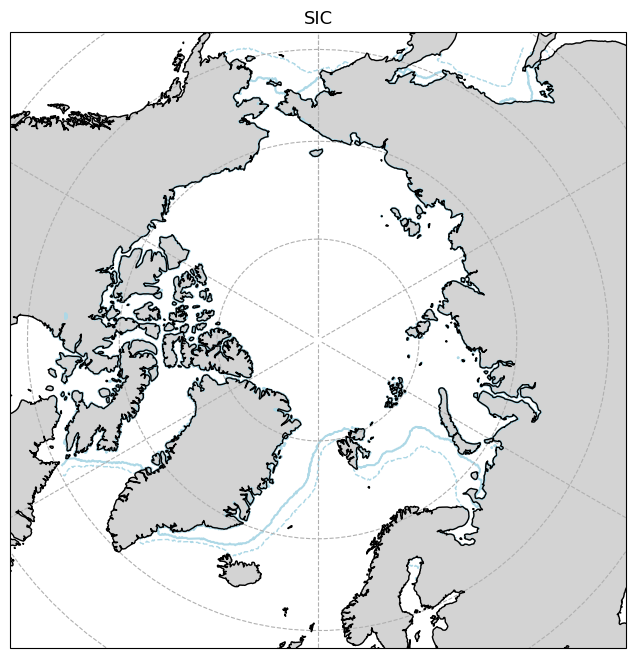

In [61]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))


contour = (NorESM_sic_his>50).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1, linestyles = '--',zorder=1)
contour = (NorESM_sic_his>85).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1.5, linestyles = '-',zorder=1)

ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, edgecolor='None') 
ax.set_title('SIC')

plt.show()

In [60]:
ds_ice_his.siconca.

<xarray.DataArray 'siconca' (time: 360, rlat: 582, rlon: 577)>
dask.array<concatenate, shape=(360, 582, 577), dtype=float32, chunksize=(10, 582, 577), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2014-12-01
    lon      (rlat, rlon) float32 dask.array<chunksize=(582, 577), meta=np.ndarray>
    lat      (rlat, rlon) float32 dask.array<chunksize=(582, 577), meta=np.ndarray>
  * rlon     (rlon) float32 -29.9 -29.8 -29.7 -29.6 ... 27.4 27.5 27.6 27.7
  * rlat     (rlat) float32 -24.2 -24.1 -24.0 -23.9 ... 33.6 33.7 33.8 33.9
Attributes:
    standard_name:  sea_ice_area_fraction
    long_name:      Sea-Ice Area Percentage (Atmospheric Grid)
    units:          %
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

In [ ]:
ds_ice_his.siconca.

In [64]:


#CNRM SIC
ds_ice_his_CNRM = xr.open_mfdataset('/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/CNRM-ESM2-1/historical/r1i1p1f2/ICON-CLM-2-6-6-1-1/v1-r1/mon/siconca/v20250601/siconca_ARC-12_CNRM-ESM2-1_historical_r1i1p1f2_CLMcom-AWI_ICON-CLM-2-6-6-1-1_v1-r1_mon_*.nc',chunks = {'time':10})
siconc_mean_his_CNRM = ds_ice_his_CNRM.siconca.sel(time=ds_ice_his_CNRM.siconca.time.dt.month.isin([12, 1, 2])).mean(dim='time') #Winter sea ice

CNRM_sic_his = siconc_mean_his_CNRM.where(((ds_land.FR_LAND+ds_lake.FR_LAKE)<0.5))



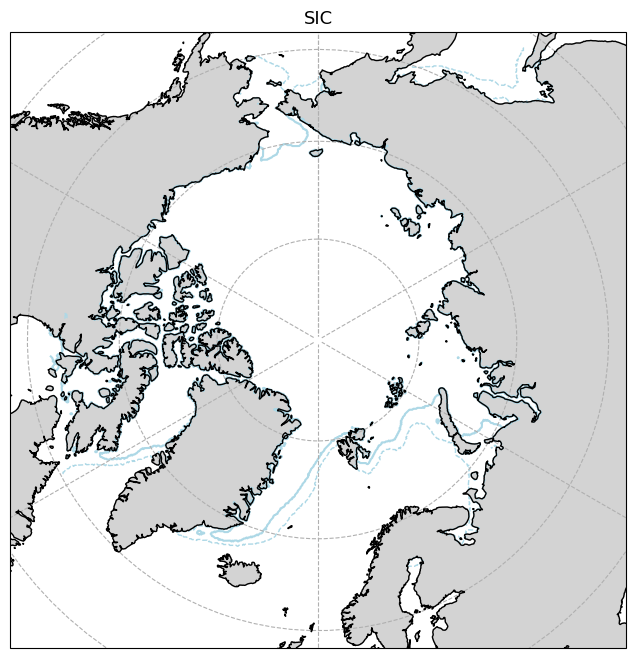

In [65]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))


contour = (CNRM_sic_his>50).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1, linestyles = '--',zorder=1)
contour = (CNRM_sic_his>85).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1.5, linestyles = '-',zorder=1)

ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, edgecolor='None') 
ax.set_title('SIC')

plt.show()

### TA 850

In [42]:
NorESM_his = xr.open_mfdataset(f'{ICON_NorESM_path_his}/6hr/ta850/v20250601/ta850_*.nc',chunks={'time': 10})

In [43]:
NorESM_ssp = xr.open_mfdataset(f'{ICON_NorESM_path_ssp}/6hr/ta850/v20250601/ta850_*.nc',chunks={'time': 10})

In [44]:
NorESM_ssp.ta850

<xarray.DataArray 'ta850' (time: 124184, rlat: 582, rlon: 577)>
dask.array<concatenate, shape=(124184, 582, 577), dtype=float32, chunksize=(10, 582, 577), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 ... 2099-12-31T18:00:00
    lon      (rlat, rlon) float64 dask.array<chunksize=(582, 577), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(582, 577), meta=np.ndarray>
  * rlon     (rlon) float64 -29.9 -29.8 -29.7 -29.6 ... 27.4 27.5 27.6 27.7
  * rlat     (rlat) float64 -24.2 -24.1 -24.0 -23.9 ... 33.6 33.7 33.8 33.9
    plev     float64 8.5e+04
Attributes:
    standard_name:  air_temperature
    long_name:      Air Temperature
    units:          K
    cell_methods:   time: point
    grid_mapping:   crs

In [45]:
NorESM_his_tas = NorESM_his.ta850.sel(time=NorESM_his.ta850.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [46]:
NorESM_ssp_tas = NorESM_ssp.ta850.sel(time=slice("2070-01-01","2099-12-31"))
NorESM_ssp_tas = NorESM_ssp_tas.sel(time=NorESM_ssp_tas.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [47]:
NorESM_ssp_tas.mean(dim=('rlat','rlon')).values

array(258.81183, dtype=float32)

In [23]:
NorESM_change_tas = NorESM_ssp_tas - NorESM_his_tas

In [24]:
NorESM_change_tas = NorESM_change_tas.compute()

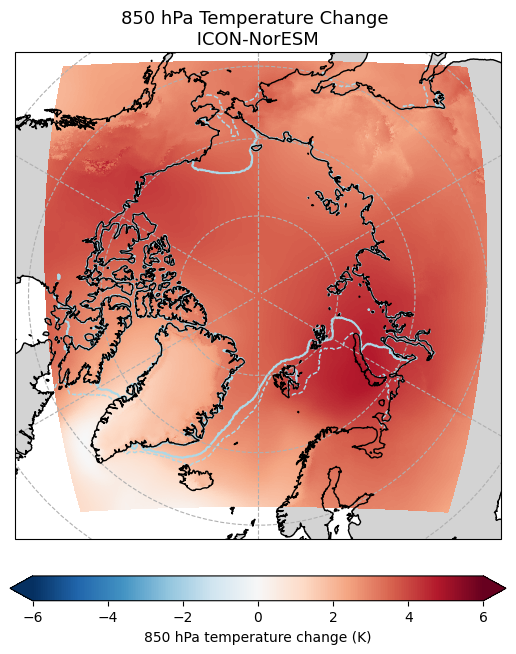

In [25]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))

NorESM_change = NorESM_change_tas.plot(ax=ax,transform=crs_rot,vmin=-6,vmax=6,cmap='RdBu_r',add_colorbar=False) #extend='both')

# Add custom colorbar
colorbar = plt.colorbar(NorESM_change, ax=ax, orientation='horizontal', pad=0.06, shrink=0.8,extend='both')
colorbar.set_label('850 hPa temperature change (K)', fontsize=10)
colorbar.ax.tick_params(labelsize=10)

contour = (NorESM_sic_ssp>50).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1, linestyles = '--',zorder=1)
contour = (NorESM_sic_ssp>85).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1.5, linestyles = '-',zorder=1)

ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, edgecolor='None') 
ax.set_title('850 hPa Temperature Change \n ICON-NorESM ')

plt.show()

In [37]:
CNRM_his = xr.open_mfdataset(f'{ICON_CNRM_path_his}/6hr/ta850/v20250601/ta850_*.nc',chunks={'time': 10})

In [38]:
CNRM_ssp = xr.open_mfdataset(f'{ICON_CNRM_path_ssp}/6hr/ta850/v20250601/ta850_*.nc',chunks={'time': 10})

In [39]:
CNRM_his_tas = CNRM_his.ta850.sel(time=CNRM_his.ta850.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [40]:
CNRM_ssp_tas = CNRM_ssp.ta850.sel(time=slice("2070-01-01","2099-12-31"))
CNRM_ssp_tas = CNRM_ssp_tas.sel(time=CNRM_ssp_tas.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [41]:
CNRM_ssp_tas.mean(dim=('rlat','rlon')).values

array(259.78436, dtype=float32)

In [30]:
CNRM_change_tas = CNRM_ssp_tas - CNRM_his_tas

In [31]:
CNRM_change_tas = CNRM_change_tas.compute()

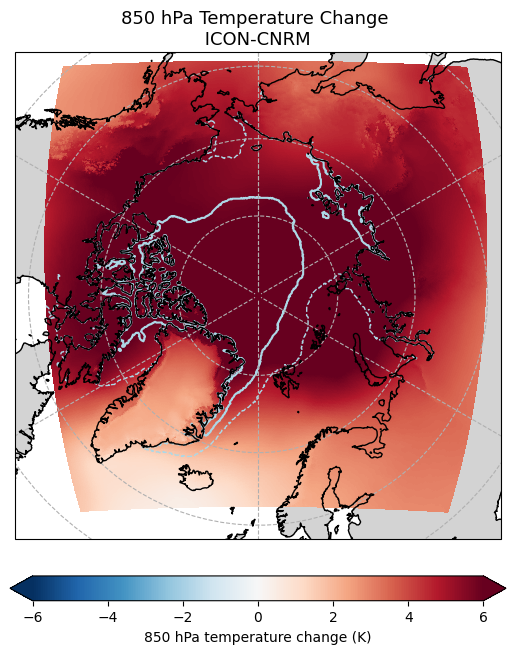

In [32]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))

CNRM_change = CNRM_change_tas.plot(ax=ax,transform=crs_rot,vmin=-6,vmax=6,cmap='RdBu_r',add_colorbar=False) #extend='both')

# Add custom colorbar
colorbar = plt.colorbar(CNRM_change, ax=ax, orientation='horizontal', pad=0.06, shrink=0.8,extend='both')
colorbar.set_label('850 hPa temperature change (K)', fontsize=10)
colorbar.ax.tick_params(labelsize=10)

contour = (CNRM_sic_ssp>50).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1, linestyles = '--',zorder=1)
contour = (CNRM_sic_ssp>85).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1.5, linestyles = '-',zorder=1)


ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, edgecolor='None') 
ax.set_title('850 hPa Temperature Change \n ICON-CNRM ')

plt.show()

In [33]:
model_differences = CNRM_change_tas - NorESM_change_tas

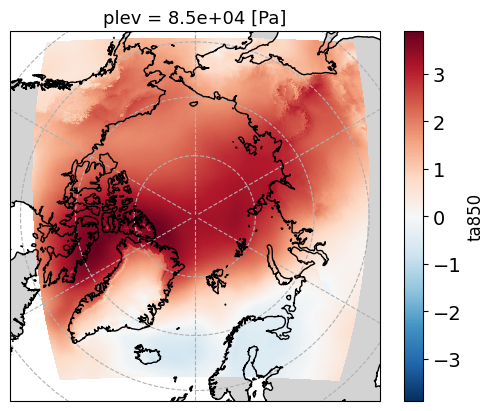

In [34]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)})

model_differences.plot(ax=ax,transform=crs_rot)

ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, edgecolor='None')

#plt.close()

#### Temperature differences

In [56]:
CNRM_change_tas.mean(dim=('rlat','rlon'))

<xarray.DataArray 'ta850' ()>
array(4.588519, dtype=float32)
Coordinates:
    plev     float64 8.5e+04

In [57]:
CNRM_change_tas.max(dim=('rlat','rlon'))

<xarray.DataArray 'ta850' ()>
array(7.405655, dtype=float32)
Coordinates:
    plev     float64 8.5e+04

In [53]:
NorESM_change_tas.mean(dim=('rlat','rlon'))

<xarray.DataArray 'ta850' ()>
array(3.0725694, dtype=float32)
Coordinates:
    plev     float64 8.5e+04

In [58]:
NorESM_change_tas.max(dim=('rlat','rlon'))

<xarray.DataArray 'ta850' ()>
array(4.896347, dtype=float32)
Coordinates:
    plev     float64 8.5e+04

### TS

In [13]:
NorESM_his_ts = xr.open_mfdataset(f'{ICON_NorESM_path_his}/day/ts/v20250601/ts_*.nc',chunks={'time': 10})

In [14]:
NorESM_ssp_ts = xr.open_mfdataset(f'{ICON_NorESM_path_ssp}/day/ts/v20250601/ts_*.nc',chunks={'time': 10})

In [15]:
NorESM_his_ts = NorESM_his_ts.ts.sel(time=NorESM_his_ts.ts.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [27]:
NorESM_ssp_ts = NorESM_ssp_ts.ts.sel(time=slice("2070-01-01","2099-12-31"))
NorESM_ssp_ts = NorESM_ssp_ts.sel(time=NorESM_ssp_ts.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [39]:
NorESM_change_ts = NorESM_ssp_ts - NorESM_his_ts

In [40]:
NorESM_change_ts = NorESM_change_ts.compute()

In [33]:
NorESM_ssp_ts.mean(dim=('rlat','rlon')).values

array(255.86867, dtype=float32)

In [59]:
NorESM_change_ts.mean(dim=('rlat','rlon'))

<xarray.DataArray 'ts' ()>
array(6.131681, dtype=float32)

In [63]:
NorESM_change_ts.max(dim=('rlat','rlon'))

<xarray.DataArray 'ts' ()>
array(24.649643, dtype=float32)

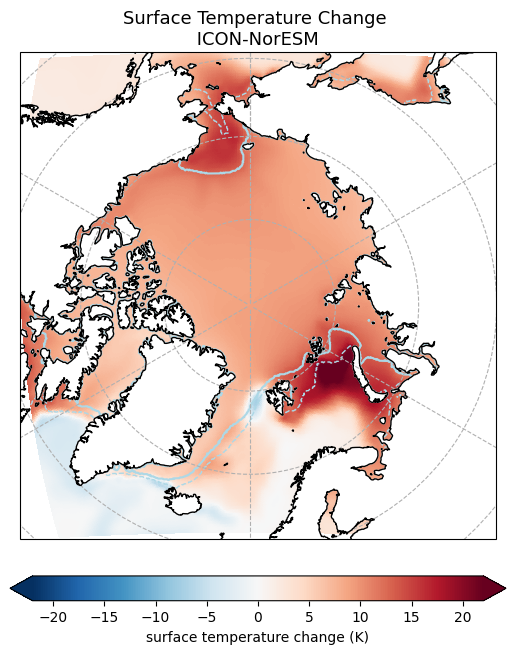

In [65]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))

NorESM_change = NorESM_change_ts.plot(ax=ax,transform=crs_rot,vmin=-22,vmax=22,cmap='RdBu_r',add_colorbar=False) #extend='both')

# Add custom colorbar
colorbar = plt.colorbar(NorESM_change, ax=ax, orientation='horizontal', pad=0.06, shrink=0.8,extend='both')
colorbar.set_label('surface temperature change (K)', fontsize=10)
colorbar.ax.tick_params(labelsize=10)


contour = (NorESM_sic_ssp>50).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1, linestyles = '--',zorder=1)
contour = (NorESM_sic_ssp>85).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1.5, linestyles = '-',zorder=1)

#ax.set_extent([15, 95, 65, 85], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='white',zorder=1, edgecolor='k') 
ax.set_title('Surface Temperature Change \n ICON-NorESM ')

plt.show()

In [34]:
CNRM_his_ts = xr.open_mfdataset(f'{ICON_CNRM_path_his}/day/ts/v20250601/ts_*.nc',chunks={'time': 10})
CNRM_ssp_ts = xr.open_mfdataset(f'{ICON_CNRM_path_ssp}/day/ts/v20250601/ts_*.nc',chunks={'time': 10})

CNRM_his_ts = CNRM_his_ts.ts.sel(time=CNRM_his_ts.ts.time.dt.month.isin([12, 1, 2])).mean(dim='time')
CNRM_ssp_ts = CNRM_ssp_ts.ts.sel(time=slice("2070-01-01","2099-12-31"))
CNRM_ssp_ts = CNRM_ssp_ts.sel(time=CNRM_ssp_ts.time.dt.month.isin([12, 1, 2])).mean(dim='time')

In [36]:
CNRM_ssp_ts.mean(dim=('rlat','rlon')).values

array(259.40393, dtype=float32)

In [11]:
CNRM_change_ts = CNRM_ssp_ts - CNRM_his_ts

In [44]:
CNRM_change_ts = CNRM_change_ts.compute()

In [61]:
CNRM_change_ts.max(dim=('rlat','rlon'))

<xarray.DataArray 'ts' ()>
array(32.928665, dtype=float32)

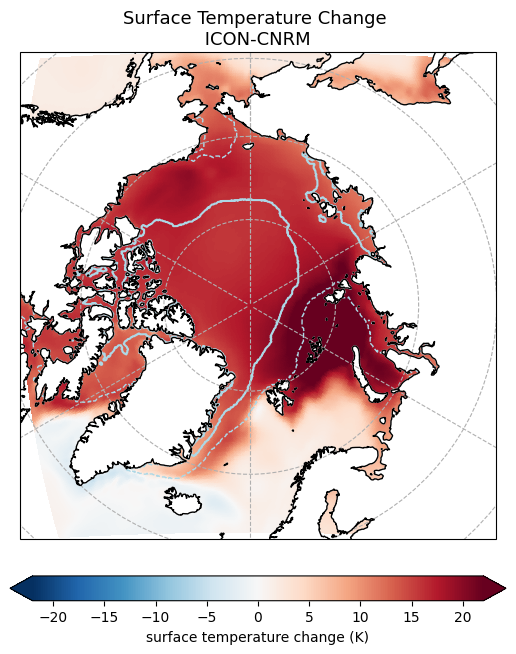

In [64]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))

CNRM_change = CNRM_change_ts.plot(ax=ax,transform=crs_rot,vmin=-22,vmax=22,cmap='RdBu_r',add_colorbar=False) #extend='both')

# Add custom colorbar
colorbar = plt.colorbar(CNRM_change, ax=ax, orientation='horizontal', pad=0.06, shrink=0.8,extend='both')
colorbar.set_label('surface temperature change (K)', fontsize=10)
colorbar.ax.tick_params(labelsize=10)


contour = (CNRM_sic_ssp>50).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1, linestyles = '--',zorder=1)
contour = (CNRM_sic_ssp>85).plot.contour(levels=1, ax = ax, transform = crs_rot, colors = 'lightblue', linewidths = 1.5, linestyles = '-',zorder=1)

#ax.set_extent([20, 90, 70, 85], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='white',zorder=1, edgecolor='k') 
ax.set_title('Surface Temperature Change \n ICON-CNRM ')

plt.show()

In [46]:
### Subplot

In [47]:
def plot_panel(ax, data, sic, sic_his, title, vmin, vmax, cbar_label, extent,sea_only=False):
    pcm = data.plot(ax=ax, transform=crs_rot, vmin=vmin, vmax=vmax,
                    cmap='RdBu_r', add_colorbar=False)
    cbar = plt.colorbar(pcm, ax=ax, orientation='horizontal',
                        pad=0.06, shrink=0.7, extend='both')
    cbar.set_label(cbar_label, fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    (sic_his > 50).plot.contour(ax=ax, transform=crs_rot, levels=1,
                            colors='purple', linewidths=1, linestyles='--', zorder=1)

    (sic > 50).plot.contour(ax=ax, transform=crs_rot, levels=1,
                            colors='lightblue', linewidths=1, linestyles='--', zorder=1)
    (sic > 85).plot.contour(ax=ax, transform=crs_rot, levels=1,
                            colors='lightblue', linewidths=1.5, linestyles='-', zorder=1)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', zorder=3)
    ax.coastlines(zorder=2)
    if sea_only: 
        ax.add_feature(cartopy.feature.LAND, color='white', zorder=1, edgecolor='k')
    else: 
        ax.add_feature(cartopy.feature.LAND, color='white', zorder=0, edgecolor='k')
    ax.set_title(title,fontsize=16)



NameError: name 'NorESM_sic_his' is not defined

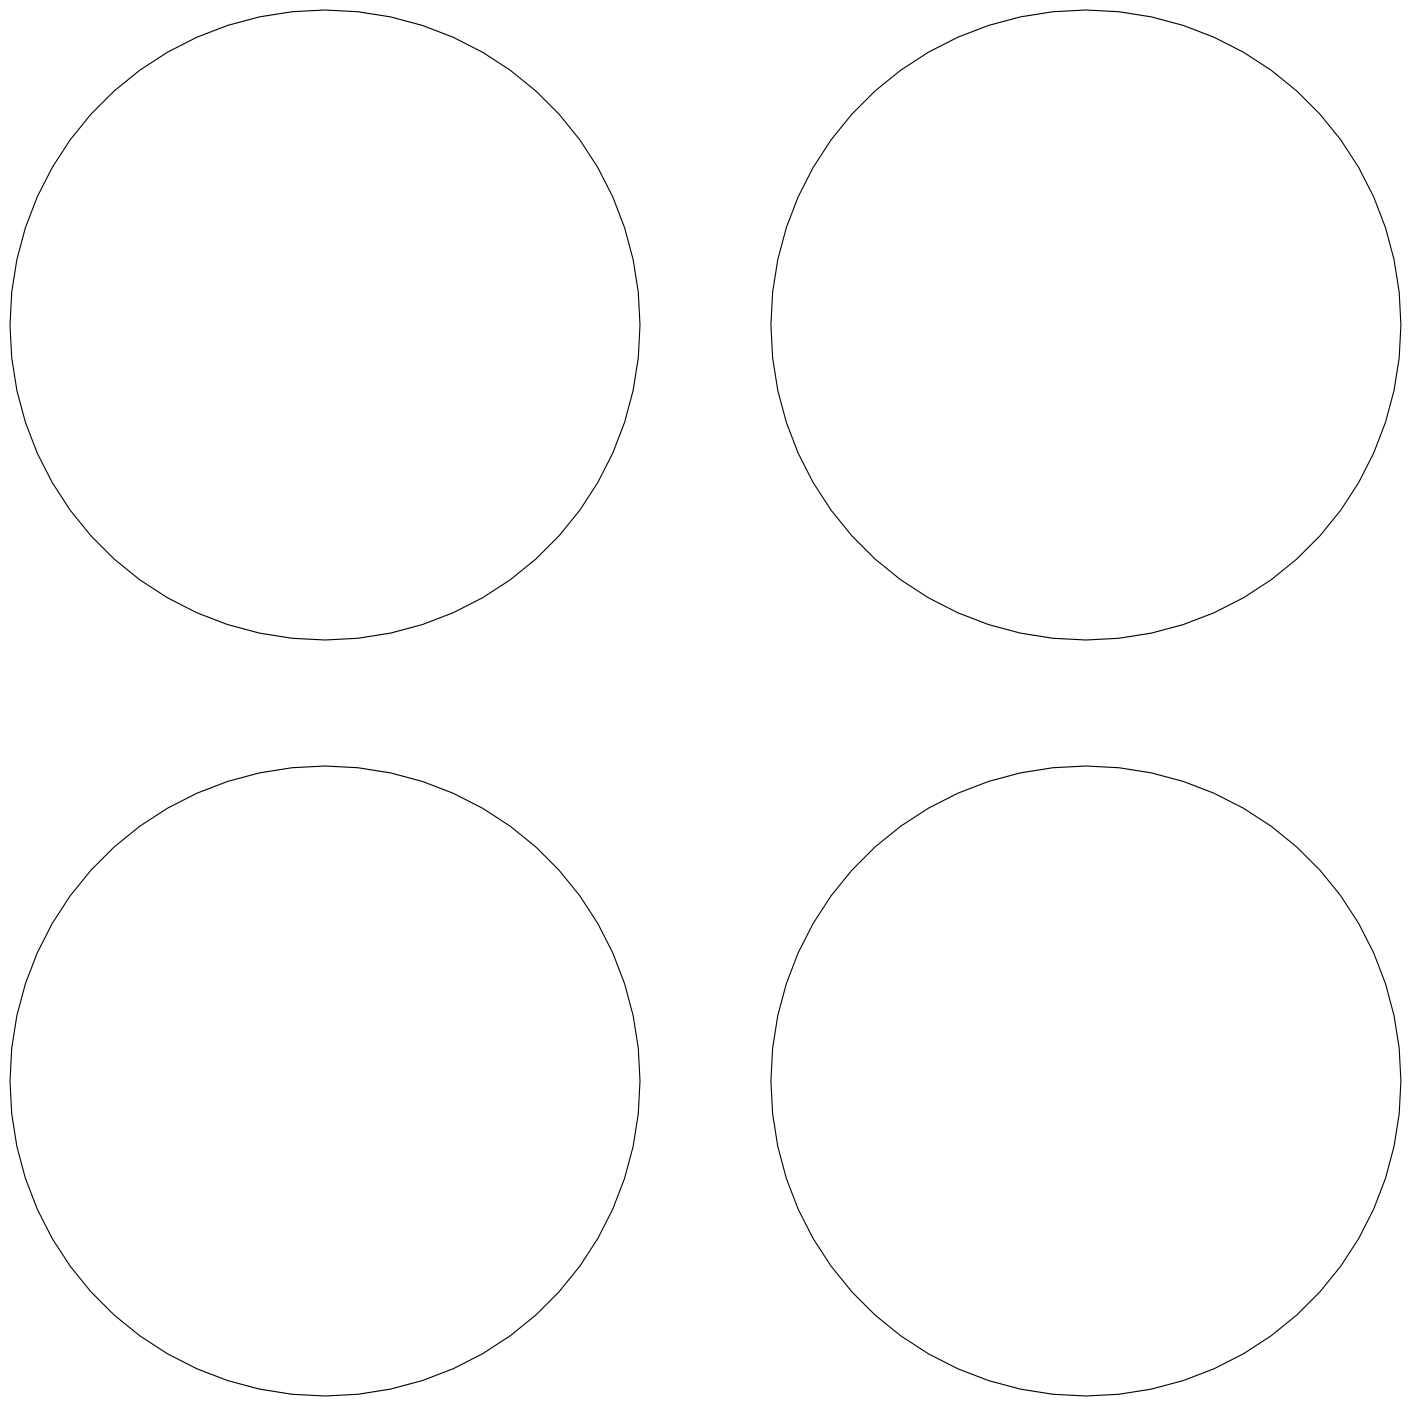

In [48]:

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.Orthographic(0, 90)}, figsize=(18, 18))
axs = axs.flatten()

# Panel definitions
plot_panel(axs[0], NorESM_change_tas, NorESM_sic_ssp, NorESM_sic_his,
           '850 hPa Temperature Change \n ICON-NorESM',
           -8, 8, '850 hPa temperature change (K)', [-180, 180, 58, 90])

plot_panel(axs[1], CNRM_change_tas, CNRM_sic_ssp, CNRM_sic_his,
           '850 hPa Temperature Change \n ICON-CNRM',
           -8, 8, '850 hPa temperature change (K)', [-180, 180, 58, 90])

plot_panel(axs[2], NorESM_change_ts, NorESM_sic_ssp, NorESM_sic_his,
           'Sea Surface Temperature Change \n ICON-NorESM',
           -22, 22, 'Sea surface temperature change (K)', [15, 95, 66, 90],sea_only=True)

plot_panel(axs[3], CNRM_change_ts, CNRM_sic_ssp, CNRM_sic_his,
           'Sea Surface Temperature Change \n ICON-CNRM',
           -22, 22, 'Sea surface temperature change (K)', [15, 95, 66, 90],sea_only=True)

plt.tight_layout()

plt.savefig('ICON-CNRM-NorESM-Storyline.png',format='png',dpi=300,bbox_inches='tight')
plt.show()


In [13]:
tas_ts_ERA5_remapped = xr.open_dataset('/work/aa0049/a271122/ERA5/remapped_tas_DJF_timeseries_1979-2022_2D.nc')

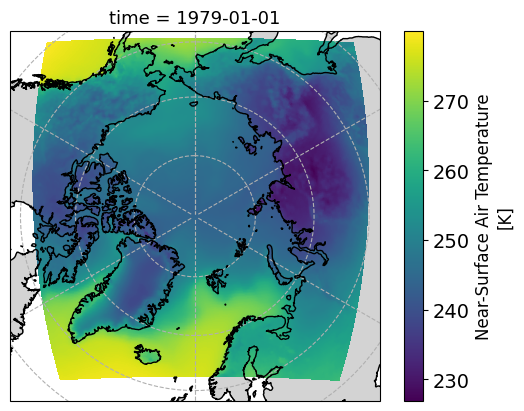

In [14]:
#tas_ts_ERA5_remapped.tas[0,:,:]

fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)})

tas_ts_ERA5_remapped.tas[0,:,:].plot(ax=ax,transform=crs_rot)

ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--',zorder=3)
ax.coastlines(zorder=2)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, edgecolor='None')

#plt.close()

In [15]:
tas_ts_ERA5_remapped.tas.mean(dim=('rlat','rlon'))

<xarray.DataArray 'tas' (time: 44)>
array([251.8694 , 254.27037, 254.70157, 253.50078, 253.85995, 254.03076,
       253.4992 , 254.12677, 252.96072, 253.51007, 254.0614 , 253.39134,
       253.71414, 254.02405, 254.11111, 252.7266 , 254.68408, 254.22914,
       253.46431, 252.82758, 253.37442, 254.59239, 253.89746, 254.18289,
       254.42685, 254.4367 , 255.04776, 255.09598, 255.56795, 255.29575,
       254.86694, 254.78485, 255.02269, 255.72044, 254.42049, 255.59875,
       255.60312, 256.42517, 256.03925, 256.78244, 255.47466, 255.72176,
       254.8506 , 255.2422 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2022-01-01

In [11]:
tas_ts_ICON_CNRM = xr.open_mfdataset('/work/aa0049/a271122/ICON_CNRM/tas_DJF_Arctic_timeseries_*.nc')
tas_ts_ICON_NorESM = xr.open_mfdataset('/work/aa0049/a271122/ICON_NorESM/tas_DJF_Arctic_timeseries_*.nc')



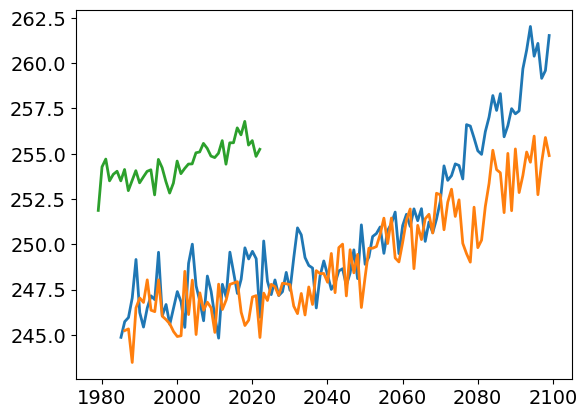

In [16]:


plt.plot(tas_ts_ICON_CNRM.time,tas_ts_ICON_CNRM.tas.mean(dim=('lat','lon')))
#plt.plot(tas_ts_ICON_CNRM_ssp.time,tas_ts_ICON_CNRM_ssp.tas.mean(dim=('lat','lon')))
plt.plot(tas_ts_ICON_NorESM.time,tas_ts_ICON_NorESM.tas.mean(dim=('lat','lon')))
#plt.plot(tas_ts_ICON_NorESM_ssp.time,tas_ts_ICON_NorESM_ssp.tas.mean(dim=('lat','lon')))

plt.plot(tas_ts_ERA5_remapped.time,tas_ts_ERA5_remapped.tas.mean(dim=('rlat','rlon')))

In [83]:
ERA5_data = {'Year': pd.to_datetime(tas_ts_ERA5_remapped.time.values).year,
             'Tas': tas_ts_ERA5_remapped.tas.mean(dim=('rlat','rlon')).values}


df_ERA5_tas = pd.DataFrame(ERA5_data)

In [86]:
#df_ERA5_tas = df_ERA5_tas[0:-1]

In [81]:
df_ERA5_filtered = pd.read_csv('ERA5_filtered.csv')

In [87]:
#df_ERA5_filtered 

In [138]:
df_ERA5_all = pd.read_csv('ERA5.csv')

In [139]:
df_ERA5_all 

Year  Event Count
0   1979          245
1   1980          305
2   1981          306
3   1982          309
4   1983          288
5   1984          291
6   1985          281
7   1986          277
8   1987          309
9   1988          324
10  1989          311
11  1990          310
12  1991          304
13  1992          296
14  1993          301
15  1994          255
16  1995          287
17  1996          290
18  1997          300
19  1998          276
20  1999          288
21  2000          361
22  2001          335
23  2002          311
24  2003          316
25  2004          332
26  2005          356
27  2006          329
28  2007          321
29  2008          332
30  2009          283
31  2010          305
32  2011          353
33  2012          337
34  2013          354
35  2014          379
36  2015          380
37  2016          398
38  2017          342
39  2018          390
40  2019          356
41  2020          334
42  2021          326

Pearson r = 0.76
P-value = 4.21e-09
Fit: y=17.42x+-4195.08


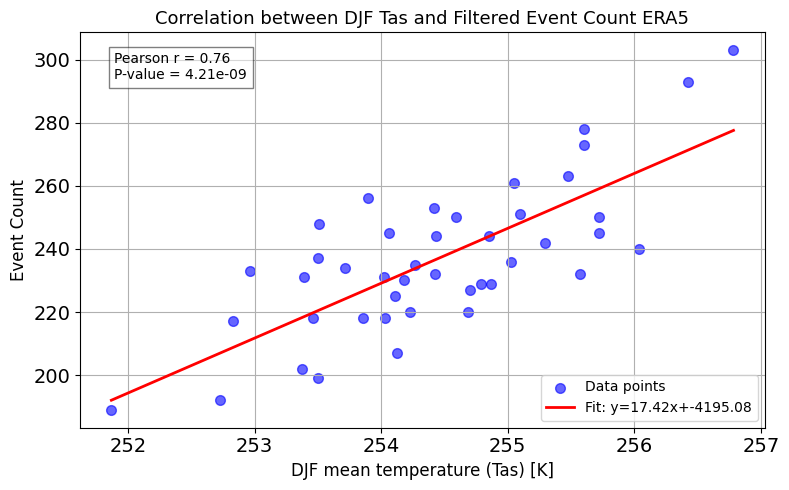

In [90]:

# Extract data as aligned arrays
x = df_ERA5_tas['Tas']
y = df_ERA5_filtered['Event Count']

# Align indices just in case


# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data points')

# Plot regression line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add correlation coefficient on the plot
plt.text(0.05, 0.95, f'Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))

# Labels and title
plt.xlabel('DJF mean temperature (Tas) [K]')
plt.ylabel('Event Count')
plt.title('Correlation between DJF Tas and Filtered Event Count ERA5')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()



print(f"Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}\nFit: y={slope:.2f}x+{intercept:.2f}")
plt.show()


In [91]:
df_ICONCNRM = pd.read_csv('ICON_CNRM_ssp.csv')
df_ICONNorESM = pd.read_csv('ICON_NorESM_ssp.csv')
df_ICONCNRM_his = pd.read_csv('ICON_CNRM_historical.csv')
df_ICONNorESM_his = pd.read_csv('ICON_NorESM_historical.csv')
df_ICONCNRM = df_ICONCNRM[:-1]

In [92]:
df_ICONCNRM_all = pd.concat([df_ICONCNRM_his,df_ICONCNRM],axis=0)

In [93]:
df_ICONNorESM_all = pd.concat([df_ICONNorESM_his,df_ICONNorESM],axis=0)

In [94]:
#df_ICONNorESM_all = df_ICONNorESM_all[1:116]

In [95]:
#df_ICONCNRM_all = df_ICONCNRM_all[1:114]

In [96]:
CNRM_data = {'Year': pd.to_datetime(tas_ts_ICON_CNRM.time.values).year,
             'Tas': tas_ts_ICON_CNRM.tas.mean(dim=('lat','lon')).values}


df_ICON_CNRM_tas = pd.DataFrame(CNRM_data)

In [97]:
#df_ICON_CNRM_tas = df_ICON_CNRM_tas[0:-1]
df_ICON_CNRM_tas 

Year         Tas
0    1985  244.864517
1    1986  245.731491
2    1987  245.957016
3    1988  247.038239
4    1989  249.160706
..    ...         ...
108  2094  262.020203
109  2095  260.379944
110  2096  261.086975
111  2097  259.158142
112  2098  259.588257

[113 rows x 2 columns]

In [177]:
df_ICONCNRM_all

Year  Event Count
1   1985          306
2   1986          291
3   1987          316
4   1988          328
5   1989          360
..   ...          ...
79  2094          528
80  2095          495
81  2096          534
82  2097          445
83  2098          566

[113 rows x 2 columns]

In [98]:
NorESM_data = {'Year': pd.to_datetime(tas_ts_ICON_NorESM.time.values).year,
               'Tas': tas_ts_ICON_NorESM.tas.mean(dim=('lat','lon')).values}

df_ICON_NorESM_tas = pd.DataFrame(NorESM_data)
    
   

In [99]:
df_ICON_NorESM_tas = df_ICON_NorESM_tas[0:-1]

In [100]:
df_ICON_NorESM_tas

Year         Tas
0    1986  245.235413
1    1987  245.329544
2    1988  243.476730
3    1989  246.490128
4    1990  247.038391
..    ...         ...
107  2094  254.528458
108  2095  255.969971
109  2096  252.737808
110  2097  254.534149
111  2098  255.892426

[112 rows x 2 columns]

In [101]:
df_ICONNorESM_all

Year  Event Count
1   1985          308
2   1986          250
3   1987          239
4   1988          284
5   1989          287
..   ...          ...
79  2094          422
80  2095          418
81  2096          449
82  2097          475
83  2098          470

[113 rows x 2 columns]

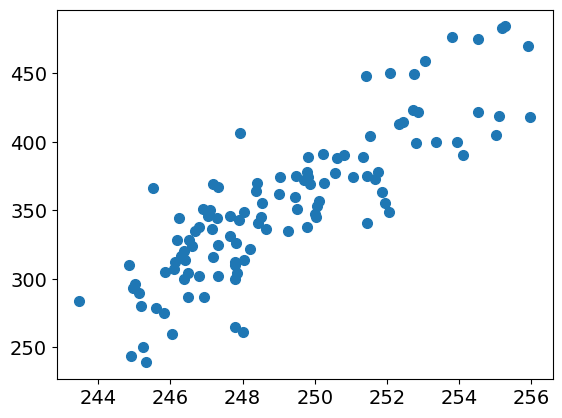

In [167]:
plt.scatter(df_ICON_NorESM_tas['Tas'],df_ICONNorESM_all['Event Count'])

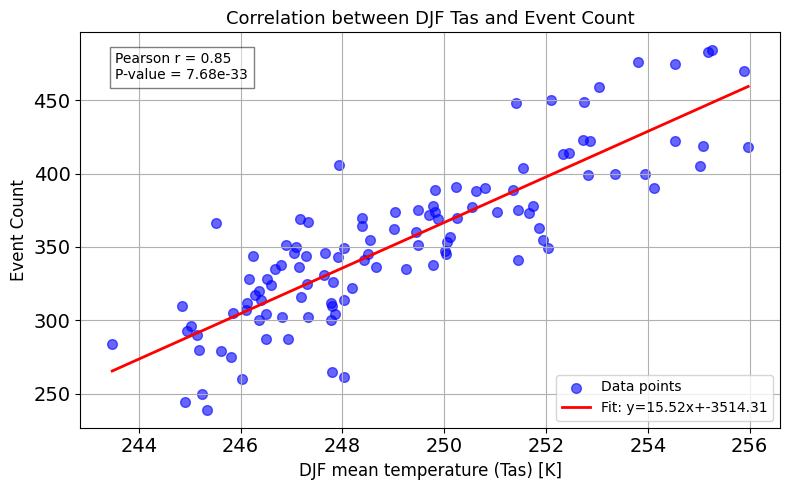

In [173]:


# Extract data as aligned arrays
x = df_ICON_NorESM_tas['Tas']
y = df_ICONNorESM_all['Event Count']

# Align indices just in case


# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data points')

# Plot regression line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add correlation coefficient on the plot
plt.text(0.05, 0.95, f'Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))

# Labels and title
plt.xlabel('DJF mean temperature (Tas) [K]')
plt.ylabel('Event Count')
plt.title('Correlation between DJF Tas and Event Count')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()


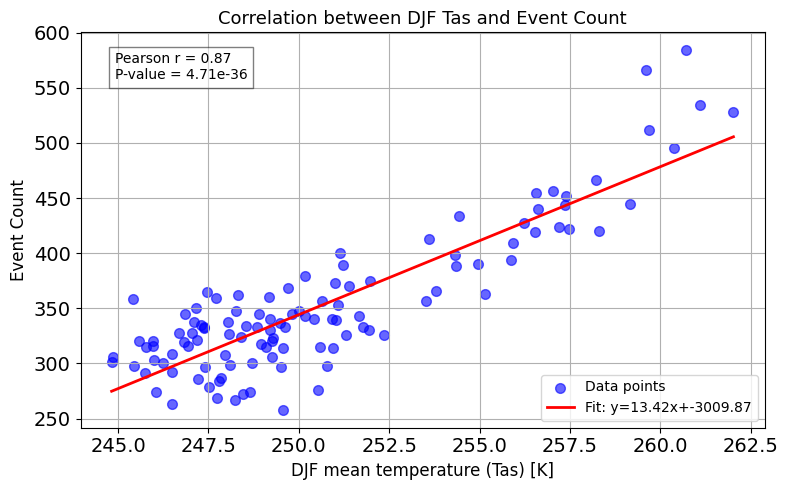

In [181]:

# Extract data as aligned arrays
x = df_ICON_CNRM_tas['Tas']
y = df_ICONCNRM_all['Event Count']

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data points')

# Plot regression line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add correlation coefficient on the plot
plt.text(0.05, 0.95, f'Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))

# Labels and title
plt.xlabel('DJF mean temperature (Tas) [K]')
plt.ylabel('Event Count')
plt.title('Correlation between DJF Tas and Event Count')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()


In [102]:
df_ICONCNRM_filtered = pd.read_csv('ICON_CNRM_filtered.csv')

In [103]:
df_ICONCNRM_filtered = df_ICONCNRM_filtered[1:114]

In [104]:
df_ICONNorESM_filtered = pd.read_csv('ICON_NorESM_filtered.csv')

In [109]:
#df_ICONNorESM_filtered = df_ICONNorESM_filtered[1:118]

In [110]:
df_ICONNorESM_filtered

Year  Event Count
2    1986          155
3    1987          156
4    1988          180
5    1989          186
6    1990          213
..    ...          ...
109  2094          272
110  2095          281
111  2096          273
112  2097          288
113  2098          301

[112 rows x 2 columns]

Pearson r = 0.85
P-value = 5.22e-32
Fit: y=9.69x+-2187.01


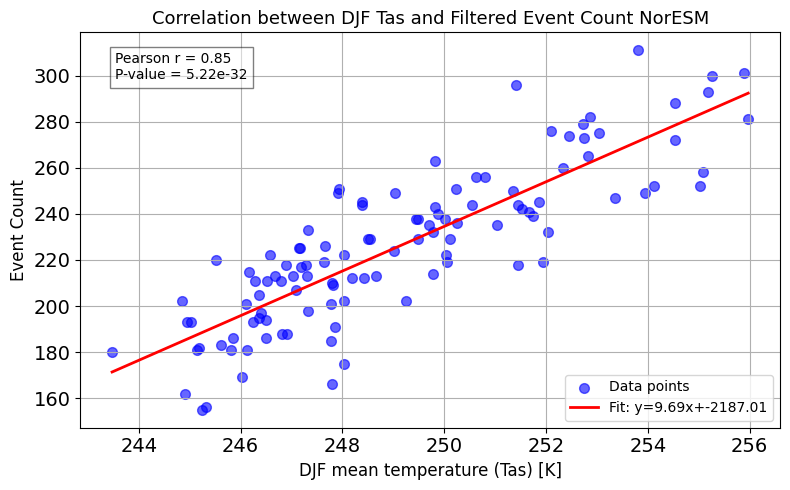

In [202]:

# Extract data as aligned arrays
x = df_ICON_NorESM_tas['Tas']
y = df_ICONNorESM_filtered['Event Count']

# Align indices just in case


# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data points')

# Plot regression line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add correlation coefficient on the plot
plt.text(0.05, 0.95, f'Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))

print(f"Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}\nFit: y={slope:.2f}x+{intercept:.2f}")
# Labels and title
plt.xlabel('DJF mean temperature (Tas) [K]')
plt.ylabel('Event Count')
plt.title('Correlation between DJF Tas and Filtered Event Count NorESM')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()


Pearson r = 0.79
P-value = 2.72e-25
Fit: y=6.08x+-1297.36


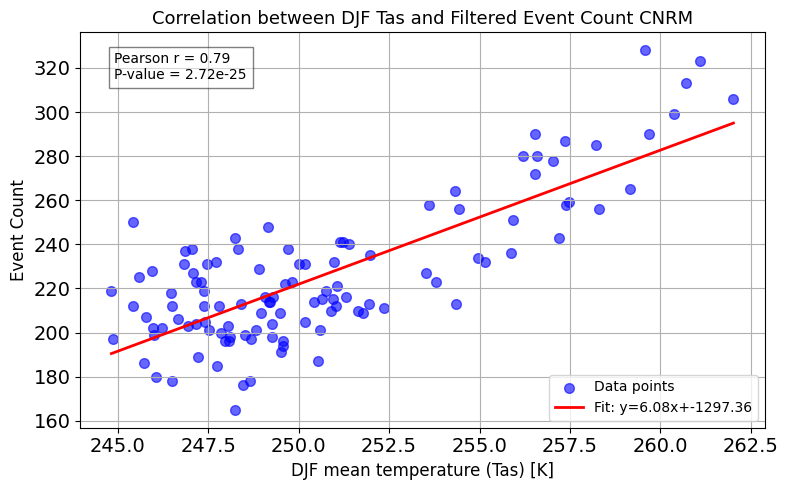

In [201]:

# Extract data as aligned arrays
x = df_ICON_CNRM_tas['Tas']
y = df_ICONCNRM_filtered['Event Count']

# Align indices just in case


# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data points')

# Plot regression line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add correlation coefficient on the plot
plt.text(0.05, 0.95, f'Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))

# Labels and title
plt.xlabel('DJF mean temperature (Tas) [K]')
plt.ylabel('Event Count')
plt.title('Correlation between DJF Tas and Filtered Event Count CNRM')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()



print(f"Pearson r = {r_value:.2f}\nP-value = {p_value:.2e}\nFit: y={slope:.2f}x+{intercept:.2f}")
plt.show()


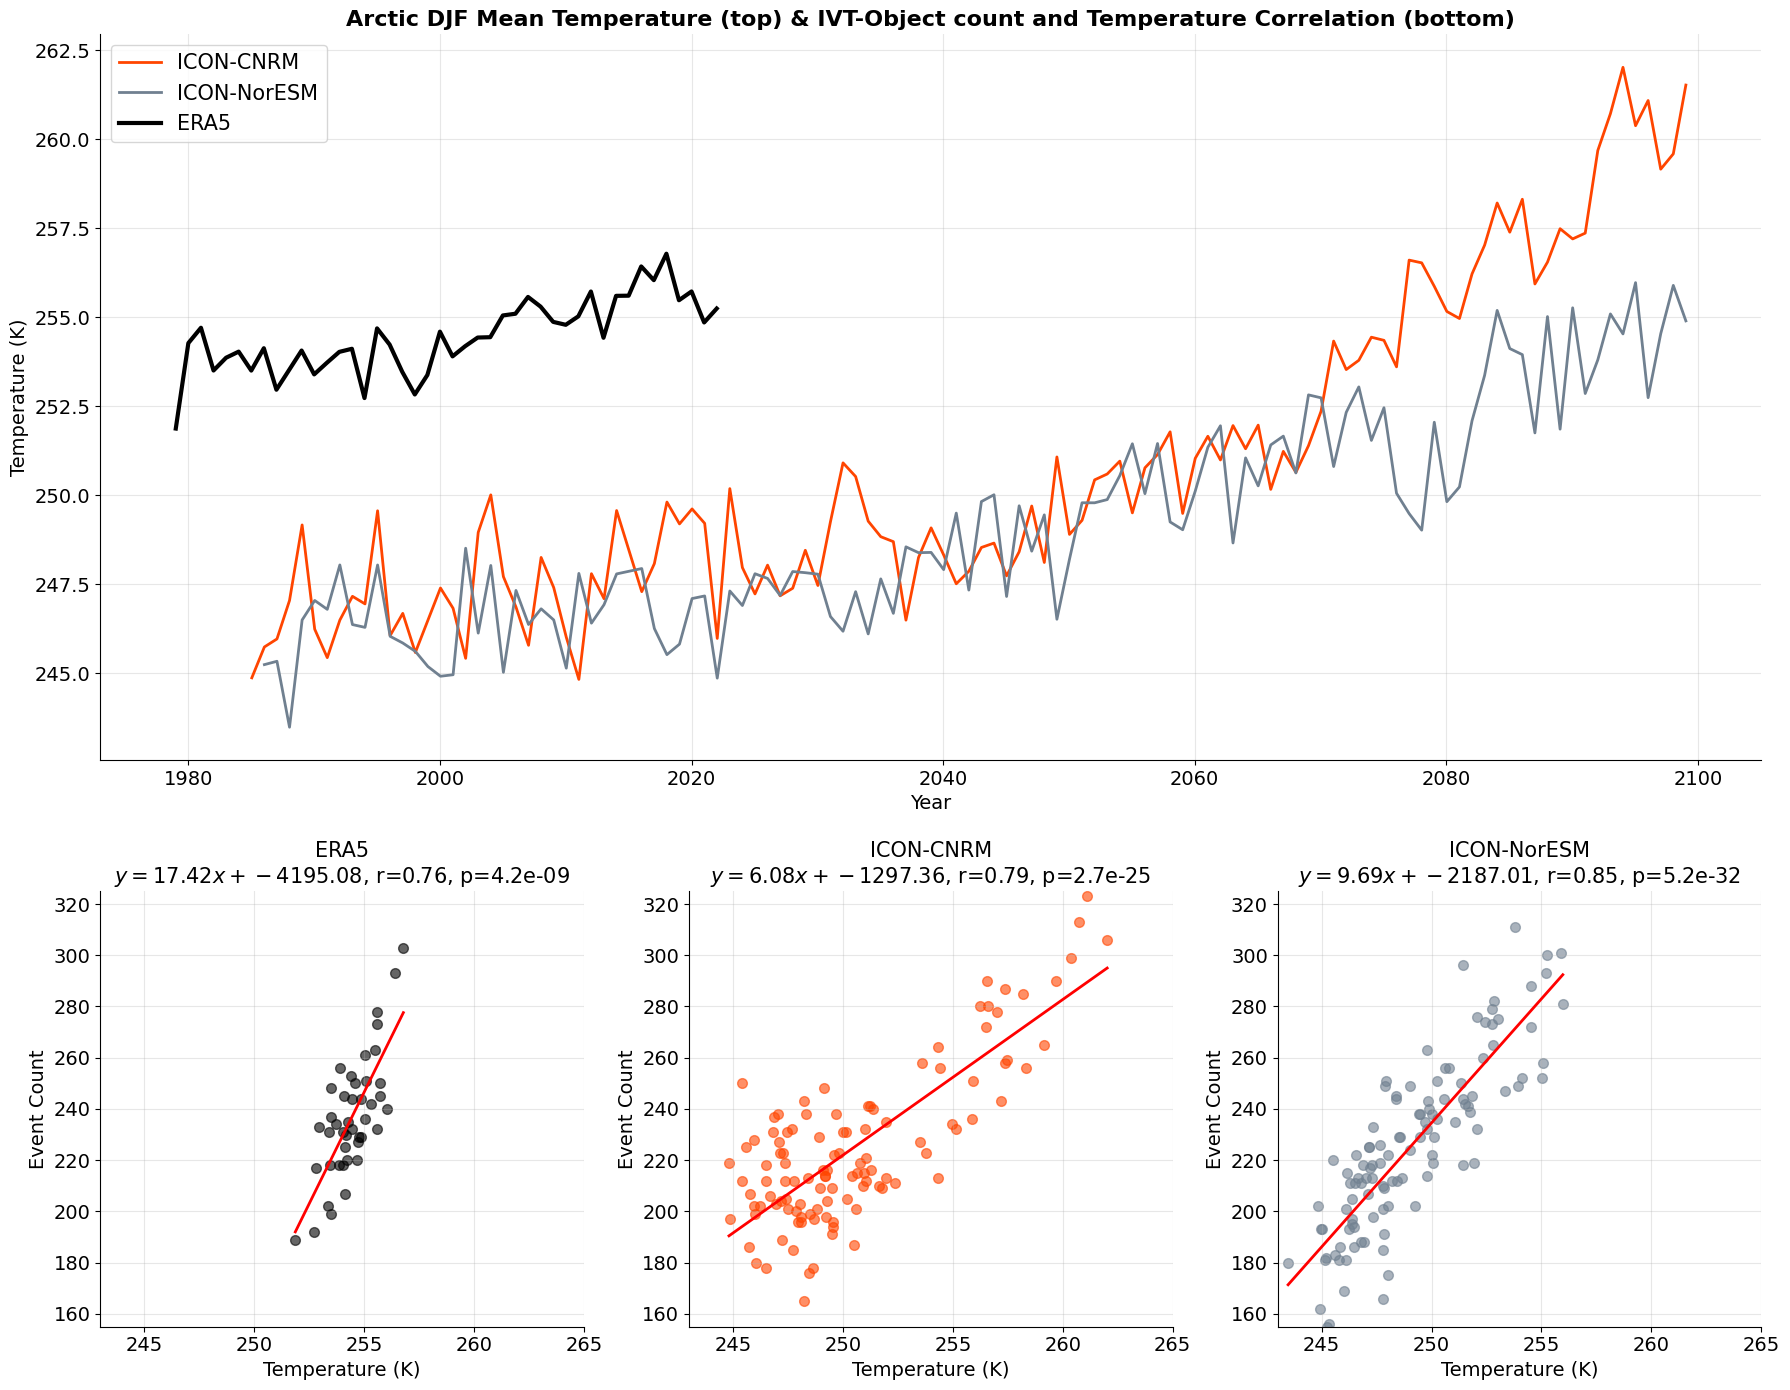

In [148]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# --- Create figure layout ---
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(2, 3, height_ratios=[2.5, 1.5])
ax_top = fig.add_subplot(gs[0, :])       # big top plot
ax_era5 = fig.add_subplot(gs[1, 0])      # bottom left
ax_cnrm = fig.add_subplot(gs[1, 1])      # bottom middle
ax_noresm = fig.add_subplot(gs[1, 2])    # bottom right

# ==============================
#  Top Panel: Temperature Timeseries
# ==============================

ax_top.plot(
    tas_ts_ICON_CNRM.time,
    tas_ts_ICON_CNRM.tas.mean(dim=('lat','lon')),
    label='ICON-CNRM', color='orangered', lw=2
)

ax_top.plot(
    tas_ts_ICON_NorESM.time,
    tas_ts_ICON_NorESM.tas.mean(dim=('lat','lon')),
    label='ICON-NorESM', color='slategrey', lw=2
)

ax_top.plot(
    tas_ts_ERA5_remapped.time,
    tas_ts_ERA5_remapped.tas.mean(dim=('rlat','rlon')),
    label='ERA5', color='black', lw=3
)

ax_top.set_title('Arctic DJF Mean Temperature (top) & IVT-Object count and Temperature Correlation (bottom)', fontsize=16, weight='bold')
ax_top.set_xlabel('Year',fontsize=14)
ax_top.set_ylabel('Temperature (K)',fontsize=14)
ax_top.grid(True, alpha=0.3)
ax_top.legend(frameon=True, fontsize=15)
ax_top.spines[['top', 'right']].set_visible(False)

# ==============================
# Helper function for correlation subplots
# ==============================

def plot_correlation(ax, x, y, title_prefix, color):
    # Linear regression
    slope, intercept, r, p, se = linregress(x, y)
    
    # Regression fit line
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept
    
    # Scatter and fit
    ax.scatter(x, y, color=color, alpha=0.6, label='Data')
    ax.plot(x_fit, y_fit, color='red', lw=2,
            label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
    
    # Title shows correlation + fit
    ax.set_title(f'{title_prefix}\n$y={slope:.2f}x+{intercept:.2f}$, r={r:.2f}, p={p:.1e}',
                 fontsize=15)
    
    # Axes labels and aesthetics
    ax.set_xlabel('Temperature (K)',fontsize=14)
    ax.set_ylabel('Event Count',fontsize=14)
    ax.set_xlim([243,265])
    ax.set_ylim([155,325])
    ax.grid(True, alpha=0.3)
    #ax.legend(fontsize=8, loc='lower right')
    ax.spines[['top', 'right']].set_visible(False)

# ==============================
# Correlation subplots
# ==============================

# ERA5
plot_correlation(
    ax_era5,
    df_ERA5_tas['Tas'],
    df_ERA5_filtered['Event Count'],
    'ERA5',
    'black'
)

# ICON-CNRM
plot_correlation(
    ax_cnrm,
    df_ICON_CNRM_tas['Tas'],
    df_ICONCNRM_filtered['Event Count'],
    'ICON-CNRM',
    'orangered'
)

# ICON-NorESM
plot_correlation(
    ax_noresm,
    df_ICON_NorESM_tas['Tas'],
    df_ICONNorESM_filtered['Event Count'],
    'ICON-NorESM',
    'slategrey'
)

# ==============================
#  Final Layout
# ==============================
plt.tight_layout(h_pad=2.0)
plt.savefig("Temperature_Comparison_Models_filtered_Events.png",format='png',dpi=300,bbox_inches='tight')


plt.show()


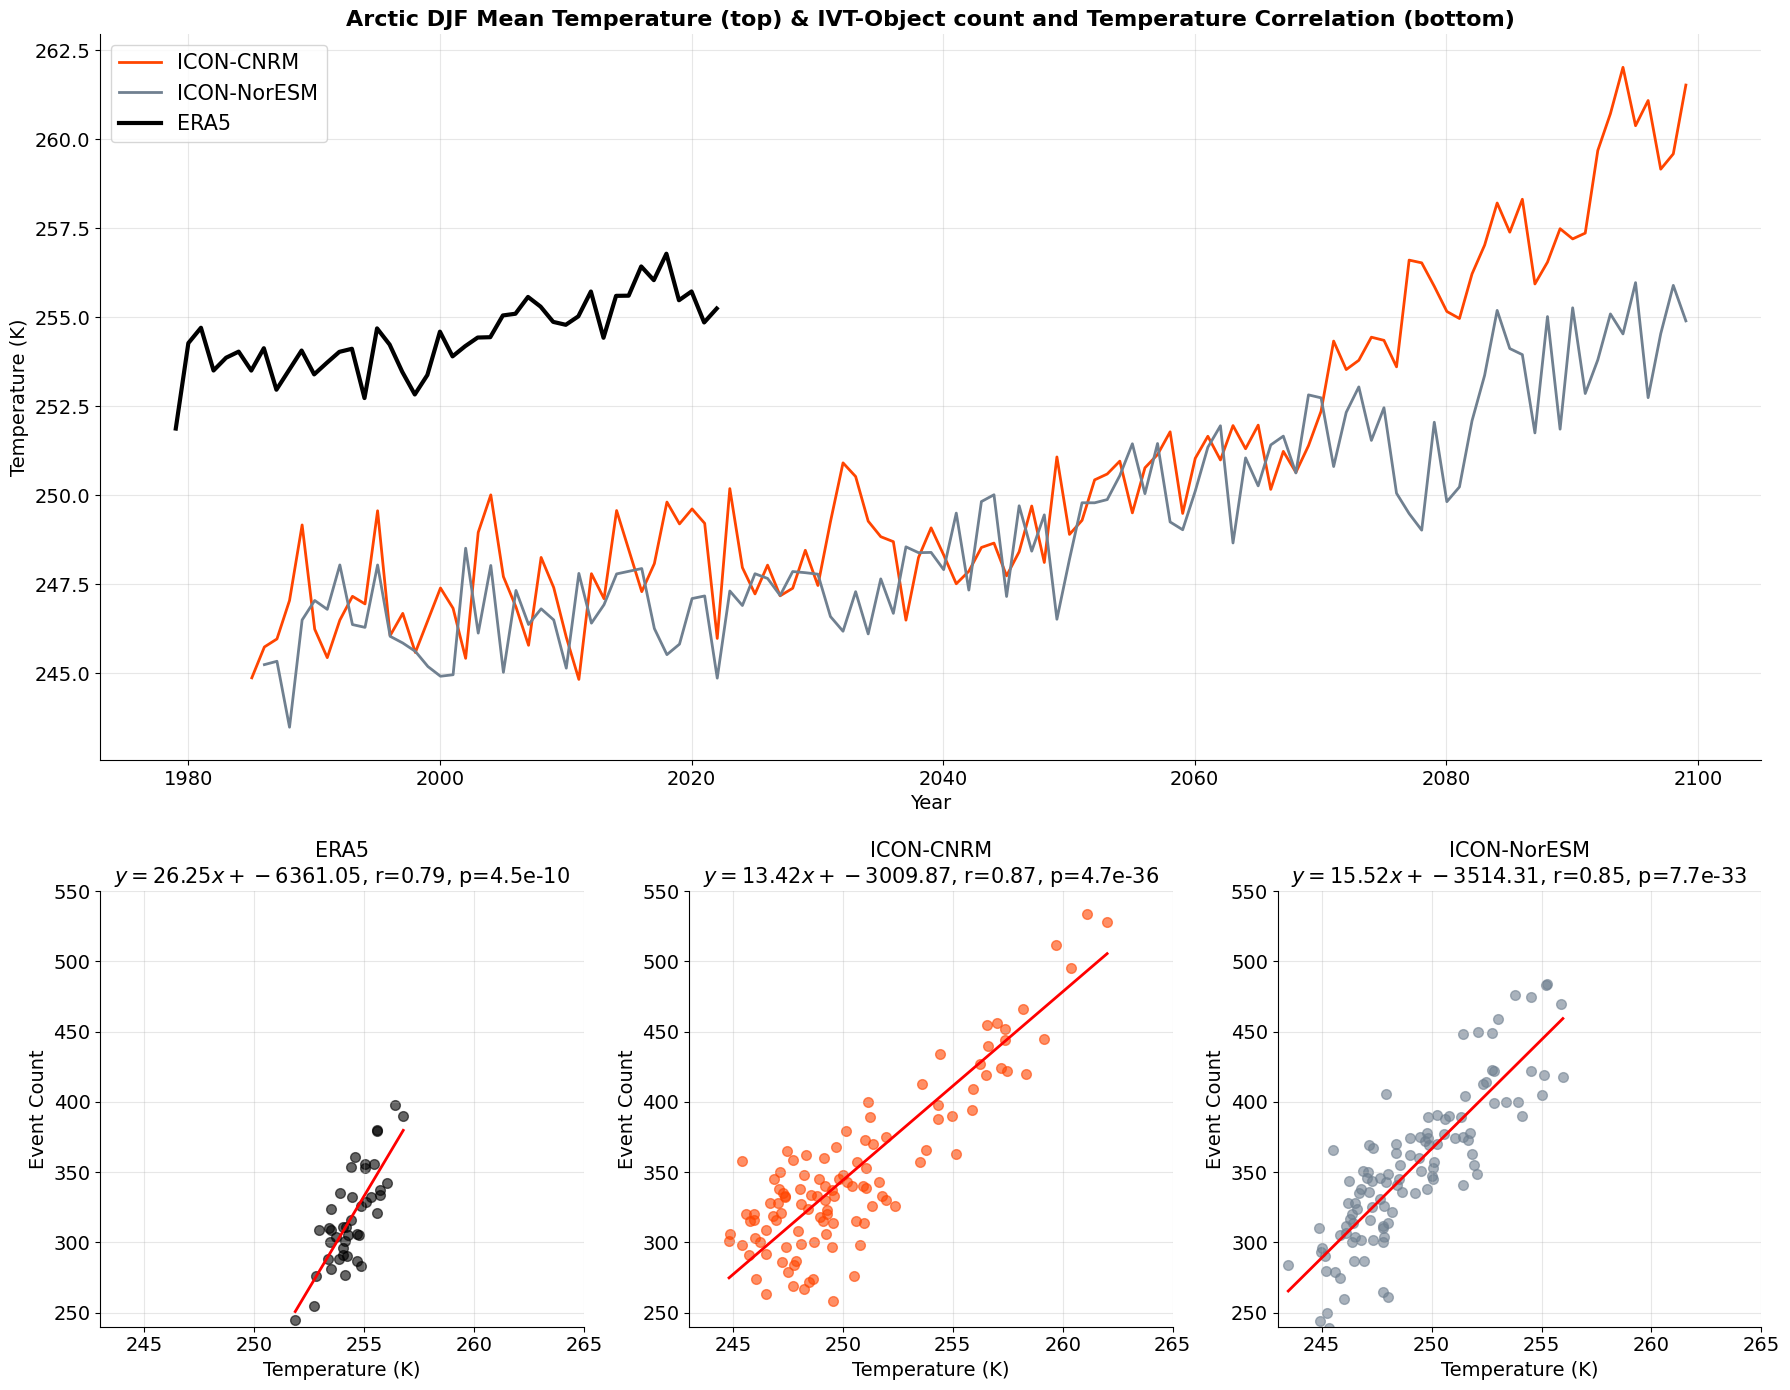

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# --- Create figure layout ---
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(2, 3, height_ratios=[2.5, 1.5])
ax_top = fig.add_subplot(gs[0, :])       # big top plot
ax_era5 = fig.add_subplot(gs[1, 0])      # bottom left
ax_cnrm = fig.add_subplot(gs[1, 1])      # bottom middle
ax_noresm = fig.add_subplot(gs[1, 2])    # bottom right

# ==============================
#  Top Panel: Temperature Timeseries
# ==============================

ax_top.plot(
    tas_ts_ICON_CNRM.time,
    tas_ts_ICON_CNRM.tas.mean(dim=('lat','lon')),
    label='ICON-CNRM', color='orangered', lw=2
)

ax_top.plot(
    tas_ts_ICON_NorESM.time,
    tas_ts_ICON_NorESM.tas.mean(dim=('lat','lon')),
    label='ICON-NorESM', color='slategrey', lw=2
)

ax_top.plot(
    tas_ts_ERA5_remapped.time,
    tas_ts_ERA5_remapped.tas.mean(dim=('rlat','rlon')),
    label='ERA5', color='black', lw=3
)

ax_top.set_title('Arctic DJF Mean Temperature (top) & IVT-Object count and Temperature Correlation (bottom)', fontsize=16, weight='bold')
ax_top.set_xlabel('Year',fontsize=14)
ax_top.set_ylabel('Temperature (K)',fontsize=14)
ax_top.grid(True, alpha=0.3)
ax_top.legend(frameon=True, fontsize=15)
ax_top.spines[['top', 'right']].set_visible(False)

# ==============================
# Helper function for correlation subplots
# ==============================

def plot_correlation(ax, x, y, title_prefix, color):
    # Linear regression
    slope, intercept, r, p, se = linregress(x, y)
    
    # Regression fit line
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept
    
    # Scatter and fit
    ax.scatter(x, y, color=color, alpha=0.6, label='Data')
    ax.plot(x_fit, y_fit, color='red', lw=2,
            label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
    
    # Title shows correlation + fit
    ax.set_title(f'{title_prefix}\n$y={slope:.2f}x+{intercept:.2f}$, r={r:.2f}, p={p:.1e}',
                 fontsize=15)
    
    # Axes labels and aesthetics
    ax.set_xlabel('Temperature (K)',fontsize=14)
    ax.set_ylabel('Event Count',fontsize=14)
    ax.set_xlim([243,265])
    ax.set_ylim([240,550])
    ax.grid(True, alpha=0.3)
    #ax.legend(fontsize=8, loc='lower right')
    ax.spines[['top', 'right']].set_visible(False)

# ==============================
# Correlation subplots
# ==============================

# ERA5
plot_correlation(
    ax_era5,
    df_ERA5_tas['Tas'],
    df_ERA5_all['Event Count'],
    'ERA5',
    'black'
)

# ICON-CNRM
plot_correlation(
    ax_cnrm,
    df_ICON_CNRM_tas['Tas'],
    df_ICONCNRM_all['Event Count'],
    'ICON-CNRM',
    'orangered'
)

# ICON-NorESM
plot_correlation(
    ax_noresm,
    df_ICON_NorESM_tas['Tas'],
    df_ICONNorESM_all['Event Count'],
    'ICON-NorESM',
    'slategrey'
)

# ==============================
#  Final Layout
# ==============================
plt.tight_layout(h_pad=2.0)
plt.savefig("Temperature_Comparison_Models_all_events.png",format='png',dpi=300,bbox_inches='tight')


plt.show()


### Climate

In [ ]:
ds_ice = xr.open_mfdataset('/work/aa0049/a271041/CMOR/ARC-11/AWI/CNRM-ESM2-1/ssp370/r1i1p1f2/AWI-ICON2-6-6/v1/mon/siconca/siconca_ARC-11_CNRM-ESM2-1_ssp370_r1i1p1f2_AWI-ICON2-6-6_v1_mon_*.nc',chunks = {'time':10})
siconc_DJF = ds_ice.siconca.sel(time=ds_ice.siconca.time.dt.month.isin([12, 1, 2])) #Winter sea ice


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
siconc_DJF.mean(dim=['rlat','rlon']).plot(color='darkblue',ax=ax)
ax.set_title('Arctic Sea-Ice Area Fraction DJF 2015-2099 (ICON_CNRM)',y=1.02)
ax.set_ylabel('Sea-Ice Area Fraction (%)')
ax.set_xlabel('Years')

plt.show()

In [ ]:
ds_tas = xr.open_mfdataset('/work/aa0049/a271041/CMOR/ARC-11/AWI/CNRM-ESM2-1/ssp370/r1i1p1f2/AWI-ICON2-6-6/v1/mon/tas/tas_ARC-11_CNRM-ESM2-1_ssp370_r1i1p1f2_AWI-ICON2-6-6_v1_mon_*.nc',chunks = {'time':10})
tas_DJF = ds_tas.tas.sel(time=ds_tas.tas.time.dt.month.isin([12, 1, 2])) #Winter sea ice

In [ ]:
tas_DJF = tas_DJF-273.15

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
tas_DJF.mean(dim=['rlat','rlon']).plot(color='darkorange',ax=ax)
ax.set_title('Arctic Monthly Mean Near-Surface Temperatures DJF 2015-2099 (ICON_CNRM)',y=1.02)
ax.set_ylabel('Near-Surface Temperature (°C)')
ax.set_xlabel('Years')

plt.show()

### Orography

In [13]:
orog = xr.open_dataset('/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/NorESM2-MM/historical/r1i1p1f1/ICON-CLM-202401-1-1/v1-r1/fx/orog/v20250601/ARC-12_NorESM2-MM_historical_r1i1p1f1_CLMcom-AWI_ICON-CLM-202401-1-1_v1-r1_fx.nc')

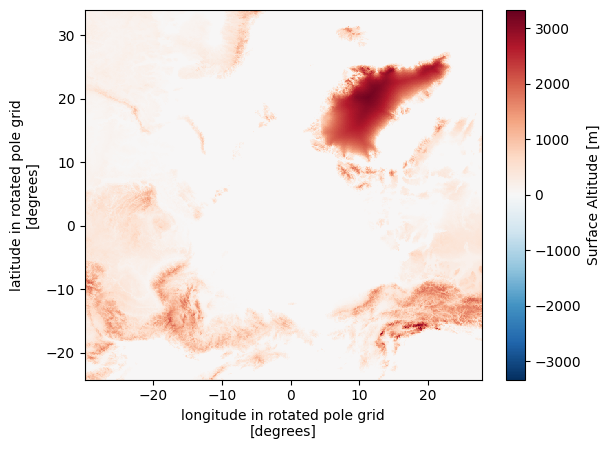

In [24]:
orog.orog.plot()

In [14]:
landfrac = xr.open_dataset('/work/aa0049/a271041/CMOR/CORDEX-CMIP6/DD/ARC-12/CLMcom-AWI/NorESM2-MM/historical/r1i1p1f1/ICON-CLM-202401-1-1/v1-r1/fx/sftlf/v20250601/ARC-12_NorESM2-MM_historical_r1i1p1f1_CLMcom-AWI_ICON-CLM-202401-1-1_v1-r1_fx.nc')

In [15]:
# Take topo and convert to a list of colors
import cmocean

cmap = cmocean.cm.topo
cmaplist = [cmap(i) for i in range(cmap.N)]

# Choose which value maps to 0
zero_color = 'lightblue'  # RGBA for white
cmaplist[cmap.N // 2] = zero_color  # roughly the middle value ~ 0

# Create new colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_topo', cmaplist, N=cmap.N)



In [16]:
landfrac.sftlf

<xarray.DataArray 'sftlf' (rlat: 582, rlon: 577)>
[335814 values with dtype=float32]
Coordinates:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
  * rlat     (rlat) float64 -24.2 -24.1 -24.0 -23.9 ... 33.6 33.7 33.8 33.9
  * rlon     (rlon) float64 -29.9 -29.8 -29.7 -29.6 ... 27.4 27.5 27.6 27.7
Attributes:
    standard_name:  land_area_fraction
    long_name:      Percentage of the Grid Cell Occupied by Land
    units:          %
    grid_mapping:   crs

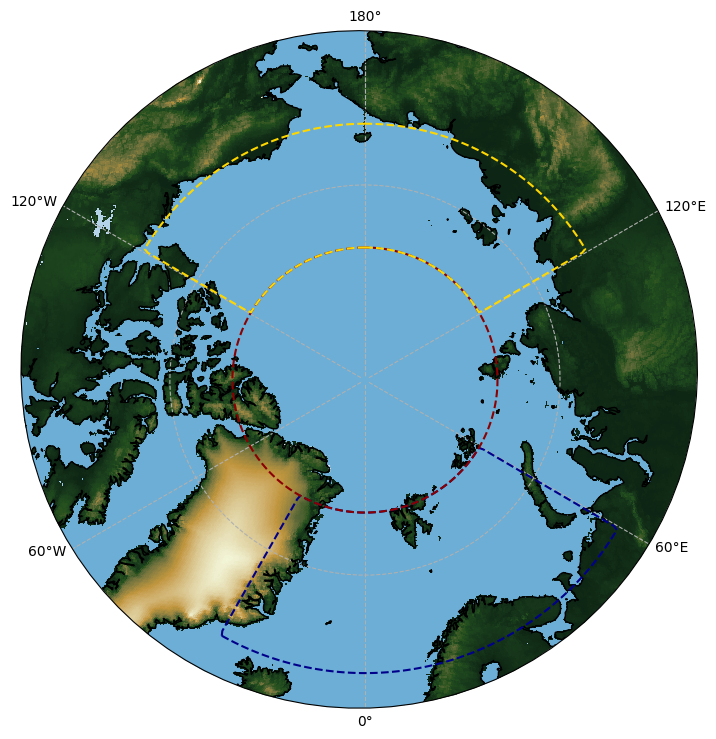

In [17]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))

orog.orog.where(landfrac.sftlf>0).plot(ax=ax,transform=crs_rot,cmap=cmocean.cm.topo,add_colorbar=False) 


orog.orog.where(landfrac.sftlf==0).plot(ax=ax,transform=crs_rot,cmap='Blues_r',add_colorbar=False) 





import matplotlib.ticker as mticker

gl = ax.gridlines(linestyle='--', zorder=3, draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))  # every 60° longitude
gl.ylocator = mticker.FixedLocator([60, 75, 90])              # only 3 latitude circles


ax.coastlines(zorder=2)
ax.set_title('')
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
for domain in domains: 
    mask_domains[domain]["mask"].plot.contour(levels=1,colors=mask_domains[domain]["color"],\
        linewidths=1.5,linestyles='--',zorder=4,ax=ax,transform=ccrs.PlateCarree())

center, radius = [0.5, 0.5], 0.55
circle = mpath.Path(np.vstack([np.sin(np.linspace(0, 2*np.pi, 100)),
                               np.cos(np.linspace(0, 2*np.pi, 100))]).T * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('Map_Arctic_Ocean.png',format='png',dpi=400)
plt.show()

In [19]:
new_orog = xr.open_dataset('/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/fx/land/orog/r1i1p1/orog_fx_reanalysis_era5_r1i1p1_19400101-20991231.nc')

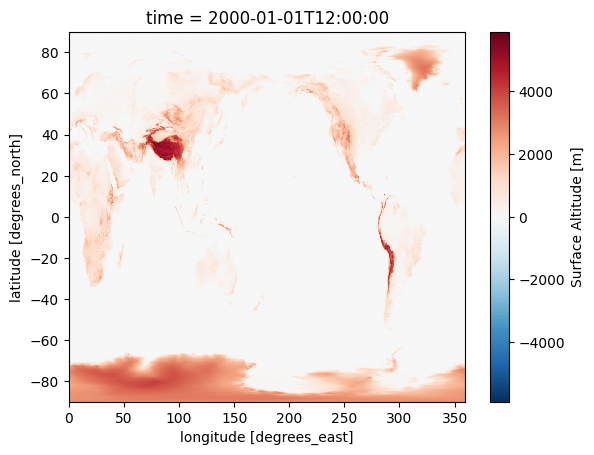

In [22]:
new_orog.orog.plot()

In [30]:
new_landfrac = xr.open_dataset('/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/fx/atmos/sftlf/r1i1p1/sftlf_fx_reanalysis_era5_r1i1p1_19400101-20991231.nc')

In [31]:
landfrac.sftlf

<xarray.DataArray 'sftlf' (rlat: 582, rlon: 577)>
array([[100., 100., 100., ...,   0.,   0.,   0.],
       [100., 100., 100., ...,   0.,   0.,   0.],
       [100., 100., 100., ...,   0.,   0.,   0.],
       ...,
       [100., 100., 100., ...,   0.,   0.,   0.],
       [100., 100., 100., ...,   0.,   0.,   0.],
       [100., 100., 100., ...,   0.,   0.,   0.]], dtype=float32)
Coordinates:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
  * rlat     (rlat) float64 -24.2 -24.1 -24.0 -23.9 ... 33.6 33.7 33.8 33.9
  * rlon     (rlon) float64 -29.9 -29.8 -29.7 -29.6 ... 27.4 27.5 27.6 27.7
Attributes:
    standard_name:  land_area_fraction
    long_name:      Percentage of the Grid Cell Occupied by Land
    units:          %
    grid_mapping:   crs

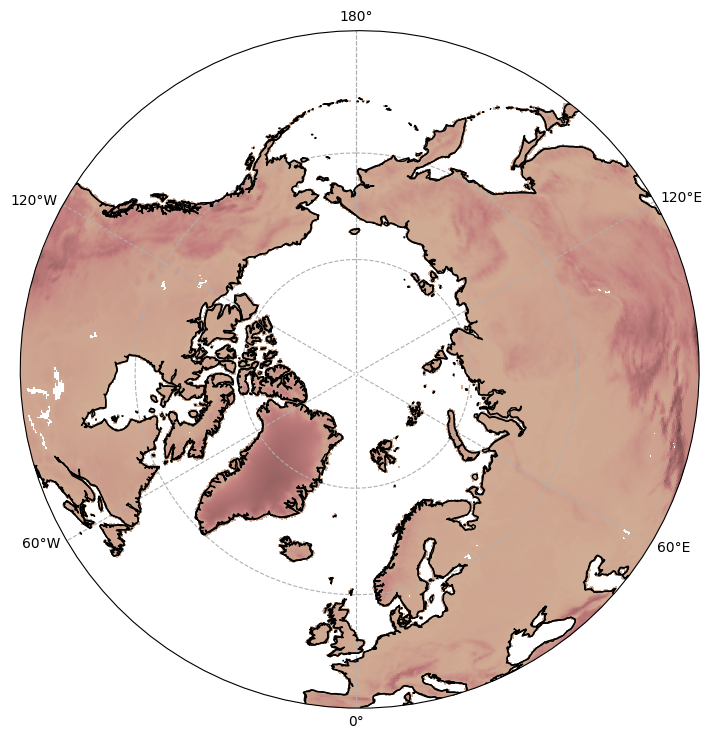

In [86]:
fig, ax = plt.subplots(1, 1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,8))

new_orog.orog.where(new_landfrac.sftlf>5).plot(ax=ax,transform=ccrs.PlateCarree(),cmap = 'pink_r',add_colorbar=False) 

#new_orog.orog.where(new_landfrac.sftlf<1).plot(ax=ax,transform=crs_rot,cmap='Blues_r',add_colorbar=False) 



import matplotlib.ticker as mticker

gl = ax.gridlines(linestyle='--', zorder=3, draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))  # every 60° longitude
gl.ylocator = mticker.FixedLocator([60, 75, 90])              # only 3 latitude circles


ax.coastlines(zorder=2)
ax.set_title('')
ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())

center, radius = [0.5, 0.5], 0.55
circle = mpath.Path(np.vstack([np.sin(np.linspace(0, 2*np.pi, 100)),
                               np.cos(np.linspace(0, 2*np.pi, 100))]).T * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
#ax.add_feature(cartopy.feature.OCEAN, color='lightblue',zorder=0, edgecolor='None') 
ax.coastlines(resolution='50m', zorder=2)

plt.savefig('Map_NH.png',format='png',dpi=400)
plt.show()